In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime

In [240]:
df_raw = pd.read_csv("Rotman MMA Summer Datathon NWHL.csv")
df_raw

,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,...,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2
0,2021-01-23,Minnesota Whitecaps,Boston Pride,1,20:00,5,5,0,0,Boston Pride,...,Faceoff Win,100,43,Backhand,NaN,NaN,NaN,Stephanie Anderson,NaN,NaN
1,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:58,5,5,0,0,Boston Pride,...,Puck Recovery,107,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:57,5,5,0,0,Boston Pride,...,Zone Entry,125,28,Carried,NaN,NaN,NaN,Maddie Rowe,NaN,NaN
3,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:55,5,5,0,0,Boston Pride,...,Shot,131,28,Snapshot,On Net,t,f,NaN,NaN,NaN
4,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:53,5,5,0,0,Boston Pride,...,Faceoff Win,169,21,Backhand,NaN,NaN,NaN,Stephanie Anderson,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26877,2021-02-01,Buffalo Beauts,Boston Pride,3,0:06,4,5,1,7,Buffalo Beauts,...,Puck Recovery,8,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26878,2021-02-01,Buffalo Beauts,Boston Pride,3,0:06,4,5,1,7,Buffalo Beauts,...,Play,8,61,Indirect,NaN,NaN,NaN,Cassidy MacPherson,29.0,82.0
26879,2021-02-01,Buffalo Beauts,Boston Pride,3,0:05,4,5,1,7,Buffalo Beauts,...,Dump In/Out,34,84,Lost,NaN,NaN,NaN,NaN,NaN,NaN
26880,2021-02-01,Buffalo Beauts,Boston Pride,3,0:03,4,5,1,7,Boston Pride,...,Puck Recovery,132,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [241]:
# To find the total number of games recorded
df_raw["Combination_Home_Away_Team"] = df_raw["Home Team"] + " & " + df_raw["Away Team"]
df_raw["game_record"] = df_raw["game_date"] + ": " + df_raw["Combination_Home_Away_Team"]
num_game = len(df_raw["game_record"].unique())
num_game

15

In [242]:
# Create index for each game
i = 1
game_index = []
for record in df_raw["game_record"].unique():
    df_temp = df_raw[df_raw["game_record"] == record]
    game_index += len(df_temp) * [i]
    i = i + 1
df_raw["game_index"] = game_index

In [96]:
# Set the event items for column names
player_profile_items = df_raw["Event"].unique().tolist()
player_profile_items.sort()
player_profile_items

['Dump In/Out',
 'Faceoff Win',
 'Goal',
 'Incomplete Play',
 'Penalty Taken',
 'Play',
 'Puck Recovery',
 'Shot',
 'Takeaway',
 'Zone Entry']

In [118]:
# For each game, aggregate the number of events happend to each player (without considering timing and )
for index in range(1, num_game + 1):
    df_game = df_raw[df_raw["game_index"] == index]
    player_list = []
    player_output = []
    for player_name in df_game["Player"].unique():
        player_data = df_game[df_game["Player"] == player_name]["Event"].value_counts()
        player_result = pd.Series(data = player_data, index = player_profile_items).fillna(0).tolist()
        player_output.append(player_result)
        player_list.append(player_name)
    df_this_game = pd.DataFrame(data = player_output, index = player_list, columns = player_profile_items)
    df_this_game.to_csv(f'game_{index}.csv', index = True)

In [119]:
# For all the games, aggregate the number of events for each player
player_list_all = []
player_output_all = []
for player_name in df_raw["Player"].unique():
    player_data = df_game[df_game["Player"] == player_name]["Event"].value_counts()
    player_result = pd.Series(data = player_data, index = player_profile_items).fillna(0).tolist()
    player_output_all.append(player_result)
    player_list_all.append(player_name)
df_all_games = pd.DataFrame(data = player_output_all, index = player_list_all, columns = player_profile_items)
df_all_games.to_csv(f'All games.csv', index = True)

In [244]:
df_raw["game_index"].value_counts()

2     1997
6     1881
5     1870
9     1827
8     1817
4     1798
11    1793
14    1772
10    1771
13    1766
12    1747
15    1745
7     1730
3     1719
1     1649
Name: game_index, dtype: int64

# Player - play periods & play duration

In [208]:
one_period = pd.Timedelta(minutes = 20)
one_period_short = pd.Timedelta(minutes = 5)

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [252]:
# Interate all the games to process periods and duration
for game_index in range(1, num_game + 1):
    game_df = df_raw[df_raw["game_index"] == game_index]
    game_df = game_df.reset_index(drop = True)
    
    # Start (1st event with the name showing up)
    game_players = game_df["Player"].unique().tolist()
    player_list_start = []
    start_period = []
    start_clock = []
    for i in range(0, len(game_df["Player"])):
        if game_players:
            if game_df["Player"][i] in game_players:
                player_list_start.append(game_df["Player"][i])
                start_period.append(game_df["Period"][i])
                start_clock.append(game_df["Clock"][i])
                game_players.remove(game_df["Player"][i])
            else:
                continue
        else:
            break
    
    # Create a dataframe for "start"
    df_start = pd.DataFrame({"Player_name" : player_list_start, "Period_Start" : start_period, "Clock_Start" : start_clock})
    
    # End (last event with the name showing up)
    game_players = game_df["Player"].unique().tolist()
    player_list_end = []
    end_period = []
    end_clock = []
    for i, row in game_df[::-1].iterrows():
        if game_players:
            if game_df["Player"][i] in game_players:
                player_list_end.append(game_df["Player"][i])
                end_period.append(game_df["Period"][i])
                end_clock.append(game_df["Clock"][i])
                game_players.remove(game_df["Player"][i])
            else:
                continue
        else:
            break
    
    # Create a dataframe for "end"
    df_end = pd.DataFrame({"Player_name" : player_list_end, "Period_End" : end_period, "Clock_End" : end_clock})
    
    # Join the two dataframe on the Player_name:
    game_period_duration_df = df_start.merge(right = df_end, how = "inner", on = "Player_name")
    
    # Change column data type
    game_period_duration_df[["Period_Start", "Period_End"]] = game_period_duration_df[["Period_Start", "Period_End"]].astype(int)
    
    # Parse the clock string and convert to timestamp
    for i in range(0, len(game_period_duration_df["Clock_Start"])):
        game_period_duration_df["Clock_Start"][i] = datetime.strptime(game_period_duration_df["Clock_Start"][i], "%M:%S")
    game_period_duration_df["Clock_Start"] = pd.to_datetime(game_period_duration_df["Clock_Start"])

    for i in range(0, len(game_period_duration_df["Clock_End"])):
        game_period_duration_df["Clock_End"][i] = datetime.strptime(game_period_duration_df["Clock_End"][i], "%M:%S")
    game_period_duration_df["Clock_End"] = pd.to_datetime(game_period_duration_df["Clock_End"])
    
    # Change timestamp format to timedelta
    game_period_duration_df["Clock_Start"] = game_period_duration_df["Clock_Start"] - datetime(1900, 1, 1)
    game_period_duration_df["Clock_End"] = game_period_duration_df["Clock_End"] - datetime(1900, 1, 1)
    
    # Calculate the duration
    duration = []
    for i in range(0, len(game_period_duration_df)):
        if game_period_duration_df["Period_End"][i] > game_period_duration_df["Period_Start"][i]:
            long_duration = (game_period_duration_df["Period_End"][i] - game_period_duration_df["Period_Start"][i] - 1) * one_period
            if game_period_duration_df["Period_End"][i] == 4:
                short_duration = one_period_short - game_period_duration_df["Clock_End"][i] + game_period_duration_df["Clock_Start"][i]
            else:
                short_duration = one_period - game_period_duration_df["Clock_End"][i] + game_period_duration_df["Clock_Start"][i]
            total_duration = long_duration + short_duration
        else:
            total_duration = game_period_duration_df["Clock_Start"][i] - game_period_duration_df["Clock_End"][i]
        duration.append(total_duration)
    
    # Add the duration into a column
    game_period_duration_df["Total_duration"] = duration
    
    # Output the dataframe as a csv file
    game_period_duration_df.to_csv(f'Game_{game_index}.csv', index = False)

<ipython-input-252-54512b190279>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_period_duration_df["Clock_Start"][i] = datetime.strptime(game_period_duration_df["Clock_Start"][i], "%M:%S")
<ipython-input-252-54512b190279>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_period_duration_df["Clock_End"][i] = datetime.strptime(game_period_duration_df["Clock_End"][i], "%M:%S")
<ipython-input-252-54512b190279>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

<ipython-input-252-54512b190279>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_period_duration_df["Clock_Start"][i] = datetime.strptime(game_period_duration_df["Clock_Start"][i], "%M:%S")
<ipython-input-252-54512b190279>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_period_duration_df["Clock_End"][i] = datetime.strptime(game_period_duration_df["Clock_End"][i], "%M:%S")
<ipython-input-252-54512b190279>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

# Single Dataframe experiment

In [250]:
game_1 = df_raw[df_raw["game_index"] == 2]
game_1 = game_1.reset_index(drop = True)

In [251]:
game_1

,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,...,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2,Combination_Home_Away_Team,game_record,game_index
0,2021-01-23,Buffalo Beauts,Connecticut Whale,1,20:00,5,5,0,0,Connecticut Whale,...,Backhand,NaN,NaN,NaN,Jordan Juron,NaN,NaN,Buffalo Beauts & Connecticut Whale,2021-01-23: Buffalo Beauts & Connecticut Whale,2
1,2021-01-23,Buffalo Beauts,Connecticut Whale,1,19:58,5,5,0,0,Connecticut Whale,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Buffalo Beauts & Connecticut Whale,2021-01-23: Buffalo Beauts & Connecticut Whale,2
2,2021-01-23,Buffalo Beauts,Connecticut Whale,1,19:58,5,5,0,0,Connecticut Whale,...,Direct,NaN,NaN,NaN,Shannon Doyle,69.0,67.0,Buffalo Beauts & Connecticut Whale,2021-01-23: Buffalo Beauts & Connecticut Whale,2
3,2021-01-23,Buffalo Beauts,Connecticut Whale,1,19:55,5,5,0,0,Connecticut Whale,...,Direct,NaN,NaN,NaN,Tori Howran,38.0,18.0,Buffalo Beauts & Connecticut Whale,2021-01-23: Buffalo Beauts & Connecticut Whale,2
4,2021-01-23,Buffalo Beauts,Connecticut Whale,1,19:54,5,5,0,0,Connecticut Whale,...,Direct,NaN,NaN,NaN,Nicole Guagliardo,90.0,9.0,Buffalo Beauts & Connecticut Whale,2021-01-23: Buffalo Beauts & Connecticut Whale,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992,2021-01-23,Buffalo Beauts,Connecticut Whale,4,0:11,4,4,1,1,Connecticut Whale,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Buffalo Beauts & Connecticut Whale,2021-01-23: Buffalo Beauts & Connecticut Whale,2
1993,2021-01-23,Buffalo Beauts,Connecticut Whale,4,0:11,4,4,1,1,Buffalo Beauts,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Buffalo Beauts & Connecticut Whale,2021-01-23: Buffalo Beauts & Connecticut Whale,2
1994,2021-01-23,Buffalo Beauts,Connecticut Whale,4,0:09,4,4,1,1,Buffalo Beauts,...,Direct,NaN,NaN,NaN,Jordan Juron,49.0,8.0,Buffalo Beauts & Connecticut Whale,2021-01-23: Buffalo Beauts & Connecticut Whale,2
1995,2021-01-23,Buffalo Beauts,Connecticut Whale,4,0:05,4,4,1,1,Buffalo Beauts,...,Indirect,NaN,NaN,NaN,Dominique Kremer,67.0,71.0,Buffalo Beauts & Connecticut Whale,2021-01-23: Buffalo Beauts & Connecticut Whale,2


In [253]:
# Start (1st event with the name showing up)
game_1_players = game_1["Player"].unique().tolist()
player_list_start = []
start_period = []
start_clock = []
for i in range(0, len(game_1["Player"])):
    if game_1_players:
        if game_1["Player"][i] in game_1_players:
            player_list_start.append(game_1["Player"][i])
            start_period.append(game_1["Period"][i])
            start_clock.append(game_1["Clock"][i])
            game_1_players.remove(game_1["Player"][i])
        else:
            continue
    else:
        break


In [198]:
df_start = pd.DataFrame({"Player_name" : player_list_start, "Period_Start" : start_period, "Clock_Start" : start_clock})
df_start

,Player_name,Period_Start,Clock_Start
0,Jillian Dempsey,1,20:00
1,McKenna Brand,1,19:58
2,Tereza Vanisova,1,19:53
3,Samantha Davis,1,19:52
4,Stephanie Anderson,1,19:50
5,Meghan Lorence,1,19:43
6,Mallory Souliotis,1,19:40
7,Taylor Wenczkowski,1,19:37
8,Sydney Baldwin,1,19:36
9,Kaleigh Fratkin,1,19:32


In [199]:
# End (last event with the name showing up)
game_1_players = game_1["Player"].unique().tolist()
player_list_end = []
end_period = []
end_clock = []
for i, row in game_1[::-1].iterrows():
    if game_1_players:
        if game_1["Player"][i] in game_1_players:
            player_list_end.append(game_1["Player"][i])
            end_period.append(game_1["Period"][i])
            end_clock.append(game_1["Clock"][i])
            game_1_players.remove(game_1["Player"][i])
        else:
            continue
    else:
        break


In [200]:
df_end = pd.DataFrame({"Player_name" : player_list_end, "Period_End" : end_period, "Clock_End" : end_clock})
df_end

,Player_name,Period_End,Clock_End
0,Meghan Lorence,3,0:01
1,Meghara McManus,3,0:03
2,Samantha Davis,3,0:05
3,Kaleigh Fratkin,3,0:06
4,Mallory Souliotis,3,0:17
5,Taylor Wenczkowski,3,0:26
6,Tereza Vanisova,3,0:28
7,Sydney Baldwin,3,0:45
8,Lauren Kelly,3,0:49
9,McKenna Brand,3,0:51


In [201]:
game_1_time_df = df_start.merge(right = df_end, how = "inner", on = "Player_name")

In [202]:
game_1_time_df

,Player_name,Period_Start,Clock_Start,Period_End,Clock_End
0,Jillian Dempsey,1,20:00,3,1:43
1,McKenna Brand,1,19:58,3,0:51
2,Tereza Vanisova,1,19:53,3,0:28
3,Samantha Davis,1,19:52,3,0:05
4,Stephanie Anderson,1,19:50,3,4:24
5,Meghan Lorence,1,19:43,3,0:01
6,Mallory Souliotis,1,19:40,3,0:17
7,Taylor Wenczkowski,1,19:37,3,0:26
8,Sydney Baldwin,1,19:36,3,0:45
9,Kaleigh Fratkin,1,19:32,3,0:06


In [203]:
game_1_time_df[["Period_Start", "Period_End"]] = game_1_time_df[["Period_Start", "Period_End"]].astype(int)

In [204]:
for i in range(0, len(game_1_time_df["Clock_Start"])):
    game_1_time_df["Clock_Start"][i] = datetime.strptime(game_1_time_df["Clock_Start"][i], "%M:%S")
game_1_time_df["Clock_Start"] = pd.to_datetime(game_1_time_df["Clock_Start"])

for i in range(0, len(game_1_time_df["Clock_End"])):
    game_1_time_df["Clock_End"][i] = datetime.strptime(game_1_time_df["Clock_End"][i], "%M:%S")
game_1_time_df["Clock_End"] = pd.to_datetime(game_1_time_df["Clock_End"])

<ipython-input-204-572ca734108f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_1_time_df["Clock_Start"][i] = datetime.strptime(game_1_time_df["Clock_Start"][i], "%M:%S")
<ipython-input-204-572ca734108f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_1_time_df["Clock_End"][i] = datetime.strptime(game_1_time_df["Clock_End"][i], "%M:%S")


In [207]:
game_1_time_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 37
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Player_name   38 non-null     object        
 1   Period_Start  38 non-null     int32         
 2   Clock_Start   38 non-null     datetime64[ns]
 3   Period_End    38 non-null     int32         
 4   Clock_End     38 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int32(2), object(1)
memory usage: 2.7+ KB


In [224]:
game_1_time_df["Clock_Start"] = game_1_time_df["Clock_Start"] - datetime(1900, 1, 1)
game_1_time_df["Clock_End"] = game_1_time_df["Clock_End"] - datetime(1900, 1, 1)

In [228]:
duration = []
for i in range(0, len(game_1_time_df)):
    if game_1_time_df["Period_End"][i] > game_1_time_df["Period_Start"][i]:
        long_duration = (game_1_time_df["Period_End"][i] - game_1_time_df["Period_Start"][i] - 1) * one_period
        if game_1_time_df["Period_End"][i] == 4:
            short_duration = one_period_short - game_1_time_df["Clock_End"][i] + game_1_time_df["Clock_Start"][i]
        else:
            short_duration = one_period - game_1_time_df["Clock_End"][i] + game_1_time_df["Clock_Start"][i]
        total_duration = long_duration + short_duration
    else:
        total_duration = game_1_time_df["Clock_Start"][i] - game_1_time_df["Clock_End"][i]
    duration.append(total_duration)

In [230]:
game_1_time_df["Total_duration"] = duration
game_1_time_df

,Player_name,Period_Start,Clock_Start,Period_End,Clock_End,Total_duration
0,Jillian Dempsey,1,0 days 00:20:00,3,0 days 00:01:43,0 days 00:58:17
1,McKenna Brand,1,0 days 00:19:58,3,0 days 00:00:51,0 days 00:59:07
2,Tereza Vanisova,1,0 days 00:19:53,3,0 days 00:00:28,0 days 00:59:25
3,Samantha Davis,1,0 days 00:19:52,3,0 days 00:00:05,0 days 00:59:47
4,Stephanie Anderson,1,0 days 00:19:50,3,0 days 00:04:24,0 days 00:55:26
5,Meghan Lorence,1,0 days 00:19:43,3,0 days 00:00:01,0 days 00:59:42
6,Mallory Souliotis,1,0 days 00:19:40,3,0 days 00:00:17,0 days 00:59:23
7,Taylor Wenczkowski,1,0 days 00:19:37,3,0 days 00:00:26,0 days 00:59:11
8,Sydney Baldwin,1,0 days 00:19:36,3,0 days 00:00:45,0 days 00:58:51
9,Kaleigh Fratkin,1,0 days 00:19:32,3,0 days 00:00:06,0 days 00:59:26


# Player cumulative time - per game

In [365]:
# Read in dataframe
df_raw = pd.read_csv("Rotman MMA Summer Datathon NWHL.csv")

# To find the total number of games recorded
df_raw["Combination_Home_Away_Team"] = df_raw["Home Team"] + " & " + df_raw["Away Team"]
df_raw["game_record"] = df_raw["game_date"] + ": " + df_raw["Combination_Home_Away_Team"]
num_game = len(df_raw["game_record"].unique())

# Create index for each game
i = 1
game_index = []
for record in df_raw["game_record"].unique():
    df_temp = df_raw[df_raw["game_record"] == record]
    game_index += len(df_temp) * [i]
    i = i + 1
df_raw["game_index"] = game_index

# Initialize dataframe
df_final = df_raw

# Collect all the game indices
game_indices = df_final["game_index"].unique().tolist()

# Iterate through all the games based on game index
for game_index in game_indices:
    game = df_final[df_final["game_index"] == game_index]
    
    # Store all the player names in this game
    player_names = game["Player"].unique().tolist()
    
    # Iterate through all the player name for cumulative play time
    for name in player_names:
        player_df = game[game["Player"] == name]
        
        # Collect the original index for the dataframe
        record_index = player_df.index.tolist()
        
        # Change the column data type "Period" --> int
        player_df["Period"] = player_df["Period"].astype(int)
        
        # Change the column data type "Clock" --> time delta
        for index in record_index:
            player_df["Clock"][index] = datetime.strptime(player_df["Clock"][index], "%M:%S")
        player_df["Clock"] = pd.to_datetime(player_df["Clock"])
        player_df["Clock"] = player_df["Clock"] - datetime(1900, 1, 1)
        
        # Calculate the cumulative play time for this player
        period_record = 1
        i_previous = record_index[0]
        player_period_cumulative = []
        current_cumu_time = pd.Timedelta(minutes = 0)
        player_period_cumulative.append(current_cumu_time)
        for i in record_index[1:]:
            if player_df["Period"][i] == period_record:
                time_diff = player_df["Clock"][i_previous] - player_df["Clock"][i]
                current_cumu_time += time_diff
                player_period_cumulative.append(current_cumu_time)
            else:
                period_record = player_df["Period"][i]
                player_period_cumulative.append(current_cumu_time)
            i_previous = i
        
        # Add the new column "Cumulative_Time_Play" to the dataframe
        player_df["Cumulative_Time_Play"] = player_period_cumulative
        
        # Only keep the target column and the index
        player_df = player_df[["Cumulative_Time_Play"]]
        
        # Map back to the original dataframe
        if "Cumulative_Time_Play" in df_final:
            df_final = df_final.combine_first(player_df)
        else:
            df_final = df_final.merge(player_df, how = "left", left_index = True, right_index = True)


<ipython-input-365-0e03c52ca982>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df["Period"] = player_df["Period"].astype(int)
<ipython-input-365-0e03c52ca982>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df["Clock"][index] = datetime.strptime(player_df["Clock"][index], "%M:%S")
D:\Anaconda\software\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

<ipython-input-365-0e03c52ca982>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df["Period"] = player_df["Period"].astype(int)
<ipython-input-365-0e03c52ca982>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df["Clock"][index] = datetime.strptime(player_df["Clock"][index], "%M:%S")
D:\Anaconda\software\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

<ipython-input-365-0e03c52ca982>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df["Period"] = player_df["Period"].astype(int)
<ipython-input-365-0e03c52ca982>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df["Clock"][index] = datetime.strptime(player_df["Clock"][index], "%M:%S")
D:\Anaconda\software\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

<ipython-input-365-0e03c52ca982>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df["Period"] = player_df["Period"].astype(int)
<ipython-input-365-0e03c52ca982>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df["Clock"][index] = datetime.strptime(player_df["Clock"][index], "%M:%S")
D:\Anaconda\software\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

# Calculate total cumulative game time - per game

In [367]:
df = df_final
one_period = pd.Timedelta(minutes = 20)
one_period_short = pd.Timedelta(minutes = 5)

In [370]:
# Iterate through all the games based on game index
for game_index in game_indices:
    game = df[df["game_index"] == game_index]
    
    # Change the column data type "Period" --> int
    game["Period"] = game["Period"].astype(int)

    # Collect the original index for the dataframe
    record_index = game.index.tolist()
    
    # Change the column data type "Clock" --> time delta
    for index in record_index:
        game["Clock"][index] = datetime.strptime(game["Clock"][index], "%M:%S")
    game["Clock"] = pd.to_datetime(game["Clock"])
    game["Clock"] = game["Clock"] - datetime(1900, 1, 1)
    
    # Calculate the total cumulative game time
    total_time_cumulative = []
    for i in record_index:
        if game["Period"][i] == 1:
            total_cumu_time = one_period - game["Clock"][i]
        else:
            long_duration = (game["Period"][i] - 1) * one_period
            if game["Period"][i] == 4:
                short_duration = one_period_short - game["Clock"][i]
            else:
                short_duration = one_period - game["Clock"][i]
            total_cumu_time = long_duration + short_duration
        total_time_cumulative.append(total_cumu_time)
        
    # Add the new column "Total_Cumulative_Time" to the dataframe
    game["Total_Cumulative_Time"] = total_time_cumulative

    # Only keep the target column and the index
    game = game[["Total_Cumulative_Time"]]

    # Map back to the original dataframe
    if "Total_Cumulative_Time" in df:
        df = df.combine_first(game)
    else:
        df = df.merge(game, how = "left", left_index = True, right_index = True)

<ipython-input-370-3a74611d0003>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game["Period"] = game["Period"].astype(int)
<ipython-input-370-3a74611d0003>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game["Clock"][index] = datetime.strptime(game["Clock"][index], "%M:%S")
D:\Anaconda\software\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

<ipython-input-370-3a74611d0003>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game["Clock"] = pd.to_datetime(game["Clock"])
<ipython-input-370-3a74611d0003>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game["Clock"] = game["Clock"] - datetime(1900, 1, 1)
<ipython-input-370-3a74611d0003>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

<ipython-input-370-3a74611d0003>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game["Clock"] = pd.to_datetime(game["Clock"])
<ipython-input-370-3a74611d0003>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game["Clock"] = game["Clock"] - datetime(1900, 1, 1)
<ipython-input-370-3a74611d0003>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

<ipython-input-370-3a74611d0003>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game["Clock"] = pd.to_datetime(game["Clock"])
<ipython-input-370-3a74611d0003>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game["Clock"] = game["Clock"] - datetime(1900, 1, 1)
<ipython-input-370-3a74611d0003>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [373]:
df.to_csv("FINAL.csv", index = False)

# Any data needs to be excluded

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv("FINAL.csv")
df

,Away Team,Away Team Goals,Away Team Skaters,Clock,Combination_Home_Away_Team,Cumulative_Time_Play,Detail 1,Detail 2,Detail 3,Detail 4,...,Player 2,Team,Total_Cumulative_Time,X Coordinate,X Coordinate 2,Y Coordinate,Y Coordinate 2,game_date,game_index,game_record
0,Boston Pride,0,5,20:00,Minnesota Whitecaps & Boston Pride,0 days 00:00:00,Backhand,NaN,NaN,NaN,...,Stephanie Anderson,Boston Pride,0 days 00:00:00,100,NaN,43,NaN,2021-01-23,1,2021-01-23: Minnesota Whitecaps & Boston Pride
1,Boston Pride,0,5,19:58,Minnesota Whitecaps & Boston Pride,0 days 00:00:00,NaN,NaN,NaN,NaN,...,NaN,Boston Pride,0 days 00:00:02,107,NaN,40,NaN,2021-01-23,1,2021-01-23: Minnesota Whitecaps & Boston Pride
2,Boston Pride,0,5,19:57,Minnesota Whitecaps & Boston Pride,0 days 00:00:01,Carried,NaN,NaN,NaN,...,Maddie Rowe,Boston Pride,0 days 00:00:03,125,NaN,28,NaN,2021-01-23,1,2021-01-23: Minnesota Whitecaps & Boston Pride
3,Boston Pride,0,5,19:55,Minnesota Whitecaps & Boston Pride,0 days 00:00:03,Snapshot,On Net,t,f,...,NaN,Boston Pride,0 days 00:00:05,131,NaN,28,NaN,2021-01-23,1,2021-01-23: Minnesota Whitecaps & Boston Pride
4,Boston Pride,0,5,19:53,Minnesota Whitecaps & Boston Pride,0 days 00:00:00,Backhand,NaN,NaN,NaN,...,Stephanie Anderson,Boston Pride,0 days 00:00:07,169,NaN,21,NaN,2021-01-23,1,2021-01-23: Minnesota Whitecaps & Boston Pride
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26877,Boston Pride,7,5,0:06,Buffalo Beauts & Boston Pride,0 days 00:31:54,NaN,NaN,NaN,NaN,...,NaN,Buffalo Beauts,0 days 00:59:54,8,NaN,61,NaN,2021-02-01,15,2021-02-01: Buffalo Beauts & Boston Pride
26878,Boston Pride,7,5,0:06,Buffalo Beauts & Boston Pride,0 days 00:31:54,Indirect,NaN,NaN,NaN,...,Cassidy MacPherson,Buffalo Beauts,0 days 00:59:54,8,29.0,61,82.0,2021-02-01,15,2021-02-01: Buffalo Beauts & Boston Pride
26879,Boston Pride,7,5,0:05,Buffalo Beauts & Boston Pride,0 days 00:54:43,Lost,NaN,NaN,NaN,...,NaN,Buffalo Beauts,0 days 00:59:55,34,NaN,84,NaN,2021-02-01,15,2021-02-01: Buffalo Beauts & Boston Pride
26880,Boston Pride,7,5,0:03,Buffalo Beauts & Boston Pride,0 days 00:45:51,NaN,NaN,NaN,NaN,...,NaN,Boston Pride,0 days 00:59:57,132,NaN,4,NaN,2021-02-01,15,2021-02-01: Buffalo Beauts & Boston Pride


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26882 entries, 0 to 26881
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Away Team                   26882 non-null  object 
 1   Away Team Goals             26882 non-null  int64  
 2   Away Team Skaters           26882 non-null  int64  
 3   Clock                       26882 non-null  object 
 4   Combination_Home_Away_Team  26882 non-null  object 
 5   Cumulative_Time_Play        26882 non-null  object 
 6   Detail 1                    17461 non-null  object 
 7   Detail 2                    1985 non-null   object 
 8   Detail 3                    1985 non-null   object 
 9   Detail 4                    1985 non-null   object 
 10  Event                       26882 non-null  object 
 11  Home Team                   26882 non-null  object 
 12  Home Team Goals             26882 non-null  int64  
 13  Home Team Skaters           268

In [12]:
# Check any situation we want to exclude
df["Player_Home_vs_Player_Away"] = df["Home Team Skaters"].astype(str) + " vs " + df["Away Team Skaters"].astype(str)
df["Player_Home_vs_Player_Away"] = df["Player_Home_vs_Player_Away"].apply(lambda x: x.replace('5 vs 6', '6 vs 5'))
df["Player_Home_vs_Player_Away"] = df["Player_Home_vs_Player_Away"].apply(lambda x: x.replace('4 vs 6', '6 vs 4'))
df["Player_Home_vs_Player_Away"] = df["Player_Home_vs_Player_Away"].apply(lambda x: x.replace('4 vs 5', '5 vs 4'))
df["Player_Home_vs_Player_Away"] = df["Player_Home_vs_Player_Away"].apply(lambda x: x.replace('3 vs 5', '5 vs 3'))
df["Player_Home_vs_Player_Away"] = df["Player_Home_vs_Player_Away"].apply(lambda x: x.replace('3 vs 4', '4 vs 3'))
df["Player_Home_vs_Player_Away"].value_counts()

5 vs 5    20393
5 vs 4     5379
4 vs 4      591
5 vs 3      247
6 vs 5      151
4 vs 3       86
6 vs 4       35
Name: Player_Home_vs_Player_Away, dtype: int64

In [30]:
# Process the sequential events (4 events) before the goal
goal_player_name = []
sequential_events_5 = []
players_in_events = []
other_players_in_events = []
for i in range(0, len(df["Event"])):
    if df["Event"][i] == "Goal":
        goal_player_name.append(df["Player"][i])
        events = []
        players = []
        other_players = []
        for j in range(0, 5):
            events.append(df["Event"][i - j])
            players.append(df["Player"][i - j])
            other_players.append(df["Player 2"][i - j])
        sequential_events_5.append(events[::-1])
        players_in_events.append(players[::-1])
        other_players_in_events.append(other_players[::-1])
    else:
        continue


In [60]:
sequential_events_5

[['Takeaway', 'Zone Entry', 'Incomplete Play', 'Puck Recovery', 'Goal'],
 ['Puck Recovery', 'Zone Entry', 'Shot', 'Puck Recovery', 'Goal'],
 ['Zone Entry', 'Play', 'Shot', 'Puck Recovery', 'Goal'],
 ['Puck Recovery', 'Play', 'Play', 'Zone Entry', 'Goal'],
 ['Play', 'Play', 'Play', 'Play', 'Goal'],
 ['Puck Recovery', 'Shot', 'Puck Recovery', 'Play', 'Goal'],
 ['Puck Recovery', 'Play', 'Zone Entry', 'Play', 'Goal'],
 ['Puck Recovery', 'Dump In/Out', 'Puck Recovery', 'Puck Recovery', 'Goal'],
 ['Incomplete Play', 'Puck Recovery', 'Play', 'Play', 'Goal'],
 ['Puck Recovery', 'Play', 'Play', 'Zone Entry', 'Goal'],
 ['Puck Recovery', 'Play', 'Play', 'Zone Entry', 'Goal'],
 ['Play', 'Shot', 'Puck Recovery', 'Play', 'Goal'],
 ['Play', 'Play', 'Dump In/Out', 'Puck Recovery', 'Goal'],
 ['Play', 'Play', 'Zone Entry', 'Play', 'Goal'],
 ['Puck Recovery', 'Play', 'Shot', 'Puck Recovery', 'Goal'],
 ['Puck Recovery', 'Play', 'Zone Entry', 'Puck Recovery', 'Goal'],
 ['Puck Recovery', 'Incomplete Play', 

In [37]:
# Check the first event before goal
event_before_goal = []
for item in sequential_events_5:
    event_before_goal.append(item[-2])
event_before_goal = pd.Series(event_before_goal)
x_item = event_before_goal.value_counts().index
y_item = event_before_goal.value_counts().values

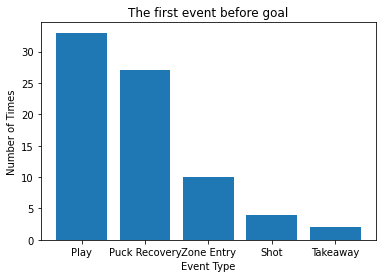

In [52]:
# Plot the events out
plt.bar(x_item, y_item)
plt.xlabel("Event Type")
plt.ylabel("Number of Times")
plt.title("The first event before goal")
plt.show()

In [54]:
# If the event before goal is a pass, keep a track of the shooter and the passer
Shooter = []
Passer = []
for i in range(0, len(sequential_events_5)):
    if sequential_events_5[i][-2] == "Play":
        Shooter.append(players_in_events[i][-2])
        Passer.append(other_players_in_events[i][-2])
    else:
        continue

In [59]:
# Check the pair (pass --> goal) player combination
Shooter = pd.Series(Shooter)
Passer = pd.Series(Passer)
Pair = Shooter + " & " + Passer
Pair.value_counts()

McKenna Brand & Jillian Dempsey               2
Kelly Babstock & Leila Kilduff                2
Taylor Turnquist & Christina Putigna          1
Lindsay Eastwood & Mikyla Grant-Mentis        1
Shiann Darkangelo & Taytum Clairmont          1
Christina Putigna & Mallory Souliotis         1
Taytum Clairmont & Mikyla Grant-Mentis        1
Kristin Lewicki & Autumn MacDougall           1
Emily Fluke & Taylor Woods                    1
Alyssa Wohlfeiler & Tori Howran               1
Alyssa Wohlfeiler & Emma Vlasic               1
Lexie Laing & Jillian Dempsey                 1
Tori Howran & Amanda Conway                   1
Shiann Darkangelo & Breanne Wilson-Bennett    1
Mikyla Grant-Mentis & Taylor Woods            1
Meghan Lorence & Haley Mack                   1
Emma Vlasic & Alyssa Wohlfeiler               1
Brooke Boquist & Taylor Woods                 1
Emma Vlasic & Katelynn Russ                   1
Emma Stauber & Meaghan Pezon                  1
Shiann Darkangelo & Lindsay Eastwood    